In [3]:
import os
import collections

DATA_PATH = '/kaggle/input/speech-assignment-dataset/speech_assignment'
all_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.wav')]

# Example: filenames like 'Arvindh_recording.wav' - assign speaker from filename prefix
speaker_files = collections.defaultdict(list)
for f in all_files:
    # Parse the speaker name from filename - adjust as per your filename format
    speaker = f.split('_')[0]  
    speaker_files[speaker].append(os.path.join(DATA_PATH, f))

print("Speakers found:", list(speaker_files.keys()))


Speakers found: ['karthayani', 'frnd', 'divya', 'dwibhashini', 'Arvindh', 'bala', 'kavin']


Speakers found: ['karthayani', 'frnd', 'divya', 'dwibhashini', 'Arvindh', 'bala', 'kavin']
Speaker karthayani total frames: 31143
Speaker frnd total frames: 37674
Speaker divya total frames: 18899
Speaker dwibhashini total frames: 28749
Speaker Arvindh total frames: 18781
Speaker bala total frames: 19893
Speaker kavin total frames: 14703
2 mixture components: Accuracy = 0.0000
4 mixture components: Accuracy = 0.0000
8 mixture components: Accuracy = 1.0000
16 mixture components: Accuracy = 1.0000


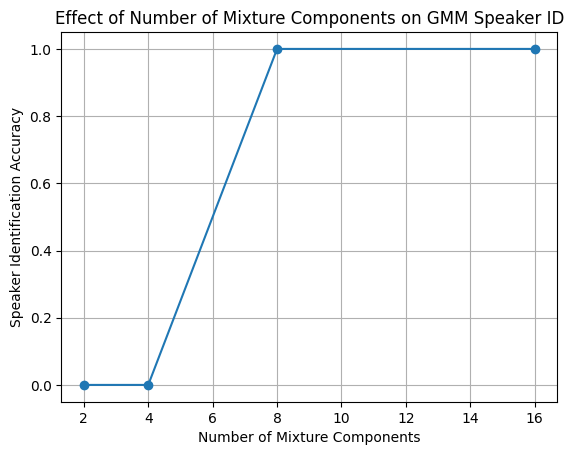

In [8]:
import os
import collections
import numpy as np
import librosa
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

DATA_PATH = '/kaggle/input/speech-assignment-dataset/speech_assignment'

# Step 1: Group files by speaker prefix
all_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.wav')]
speaker_files = collections.defaultdict(list)
for f in all_files:
    speaker = f.split('_')[0]
    speaker_files[speaker].append(os.path.join(DATA_PATH, f))

speakers = list(speaker_files.keys())
print("Speakers found:", speakers)
speaker_features = {}
for spk, files in speaker_files.items():
    feats = []
    for fpath in files:
        feats.append(extract_features(fpath))
    speaker_features[spk] = np.vstack(feats)
    print(f"Speaker {spk} total frames: {speaker_features[spk].shape[0]}")

# Step 2: Train/test split per speaker at utterance (file) level to avoid leakage
train_files = {}
test_files = {}
for spk, files in speaker_files.items():
    if len(files) > 1:
        trainf, testf = train_test_split(files, test_size=0.2, random_state=42)
    else:
        # Only one file: assign it to training for this example, or test, based on your scenario
        trainf = files
        testf = []
        # Or, to assign to testing:
        # trainf = []
        # testf = files
    train_files[spk] = trainf
    test_files[spk] = testf


# Step 3: Feature extraction defined as before
def extract_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return mfcc.T  # Time frames x n_mfcc

# Step 4: Train GMMs on train files (concatenate features per speaker)
def train_gmms(train_files, n_components):
    gmms = {}
    for spk, files in train_files.items():
        feats = []
        for fpath in files:
            mfcc = extract_features(fpath)
            feats.append(mfcc)
        feats = np.vstack(feats)
        gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=200, random_state=0)
        gmm.fit(feats)
        gmms[spk] = gmm
    return gmms

# Step 5: Evaluate on test files at utterance level
def test_gmms_utterance_level(gmms, test_files):
    y_true, y_pred = [], []
    for spk, files in test_files.items():
        for fpath in files:
            feat = extract_features(fpath)
            scores = []
            for model_spk, gmm in gmms.items():
                scores.append(gmm.score(feat))
            predicted = list(gmms.keys())[np.argmax(scores)]
            y_true.append(spk)
            y_pred.append(predicted)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

# Step 6: Experiment with different mixture components
num_components_list = [2, 4, 8, 16]
accuracies = []

for n_comp in num_components_list:
    gmms = train_gmms(train_files, n_components=n_comp)
    acc = test_gmms_utterance_level(gmms, test_files)
    accuracies.append(acc)
    print(f'{n_comp} mixture components: Accuracy = {acc:.4f}')
    # Save models for later use
    with open(f'gmm_models_{n_comp}_components.pkl', 'wb') as f:
        pickle.dump(gmms, f)

# Step 7: Plot accuracy vs mixture components
plt.figure()
plt.plot(num_components_list, accuracies, marker='o')
plt.xlabel('Number of Mixture Components')
plt.ylabel('Speaker Identification Accuracy')
plt.title('Effect of Number of Mixture Components on GMM Speaker ID')
plt.grid(True)
plt.show()


Speakers found: ['karthayani', 'frnd', 'divya', 'dwibhashini', 'Arvindh', 'bala', 'kavin']
Speaker Identification Accuracy: 1.0000


/tmp/ipykernel_37/1110680684.py:88: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_speakers))


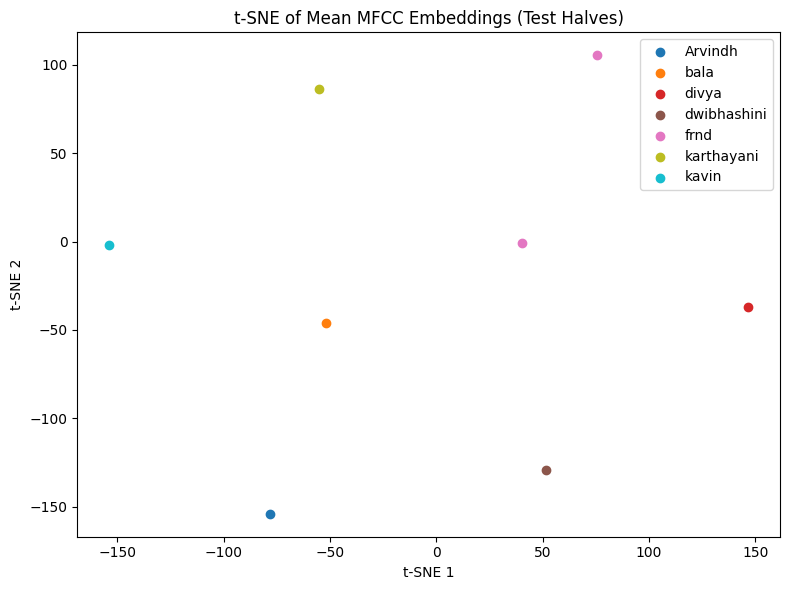

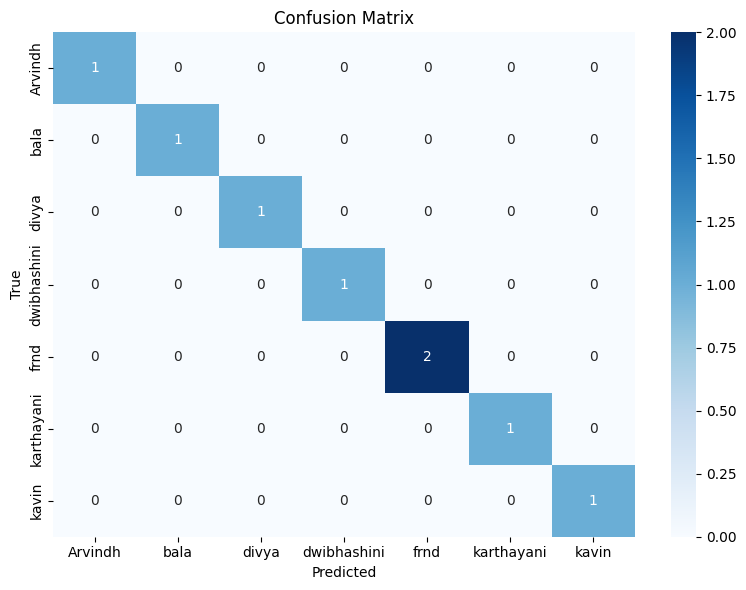

Classification Report:
              precision    recall  f1-score   support

     Arvindh       1.00      1.00      1.00         1
        bala       1.00      1.00      1.00         1
       divya       1.00      1.00      1.00         1
 dwibhashini       1.00      1.00      1.00         1
        frnd       1.00      1.00      1.00         2
  karthayani       1.00      1.00      1.00         1
       kavin       1.00      1.00      1.00         1

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



In [17]:
import os
import collections
import numpy as np
import librosa
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = '/kaggle/input/speech-assignment-dataset/speech_assignment'

# Step 1: Group WAV files by speaker prefix
all_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.wav')]
speaker_files = collections.defaultdict(list)
for f in all_files:
    speaker = f.split('_')[0]
    speaker_files[speaker].append(os.path.join(DATA_PATH, f))

speakers = list(speaker_files.keys())
print("Speakers found:", speakers)

# Step 2: New feature extraction that splits audio in two halves,
# using first half for training, second half for testing
def extract_split_features(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=16000)
    midpoint = len(y) // 2
    # Split audio signal into two halves
    first_half = y[:midpoint]
    second_half = y[midpoint:]

    # Extract MFCCs for each half
    mfcc_first = librosa.feature.mfcc(y=first_half, sr=sr, n_mfcc=n_mfcc).T
    mfcc_second = librosa.feature.mfcc(y=second_half, sr=sr, n_mfcc=n_mfcc).T
    return mfcc_first, mfcc_second

# Step 3: Prepare train and test features per speaker using halves of each file
train_features = collections.defaultdict(list)
test_features = collections.defaultdict(list)

for spk, files in speaker_files.items():
    for fpath in files:
        mfcc_train, mfcc_test = extract_split_features(fpath)
        train_features[spk].append(mfcc_train)
        test_features[spk].append(mfcc_test)

# Step 4: Train GMMs using training halves
def train_gmms_from_feats(train_feats, n_components=8):
    gmms = {}
    for spk, feats_list in train_feats.items():
        feats = np.vstack(feats_list)
        gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=200, random_state=0)
        gmm.fit(feats)
        gmms[spk] = gmm
    return gmms

# Step 5: Utterance-level testing on test halves
def test_gmms_on_feats(gmms, test_feats):
    y_true, y_pred = [], []
    for spk, feats_list in test_feats.items():
        for feats in feats_list:
            scores = [gmm.score(feats) for gmm in gmms.values()]
            predicted = list(gmms.keys())[np.argmax(scores)]
            y_true.append(spk)
            y_pred.append(predicted)
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy, y_true, y_pred

# Step 6: Train and evaluate
gmms = train_gmms_from_feats(train_features, n_components=8)
accuracy, y_true, y_pred = test_gmms_on_feats(gmms, test_features)
print(f"Speaker Identification Accuracy: {accuracy:.4f}")

# Step 7: Visualization & Metrics as before (with embeddings as mean MFCC vector per test half)

embeddings_list = [np.mean(feats, axis=0) for feats in [feat for feats_list in test_features.values() for feat in feats_list]]
unique_speakers = sorted(set(y_true))

n_samples = len(embeddings_list)
if n_samples < 2:
    print("Too few samples for t-SNE visualization")
else:
    perplexity_val = min(30, max(1, n_samples - 1))
    tsne = TSNE(n_components=2, perplexity=perplexity_val, random_state=42)
    embeddings_tsne = tsne.fit_transform(np.vstack(embeddings_list))

    plt.figure(figsize=(8, 6))
    colors = plt.cm.get_cmap('tab10', len(unique_speakers))
    for idx, spk in enumerate(unique_speakers):
        idxs = [i for i, label in enumerate(y_true) if label == spk]
        plt.scatter(embeddings_tsne[idxs, 0], embeddings_tsne[idxs, 1], label=spk, color=colors(idx))
    plt.legend(loc='best')
    plt.title('t-SNE of Mean MFCC Embeddings (Test Halves)')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.tight_layout()
    plt.show()

cm = confusion_matrix(y_true, y_pred, labels=unique_speakers)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_speakers, yticklabels=unique_speakers)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, labels=unique_speakers))


In [18]:
import pickle

# Assuming `gmms` is your dict of trained speaker GMMs from train_gmms()
model_save_path = "gmm_speaker_models.pkl"

with open(model_save_path, "wb") as f:
    pickle.dump(gmms, f)

print(f"GMM models saved to {model_save_path}")


GMM models saved to gmm_speaker_models.pkl
